In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pydlm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 635.4 kB/s eta 0:00:00


In [3]:
# 1. Các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pydlm import dlm, trend, dynamic
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason

In [4]:
#import dataset
df = pd.read_csv('/content/drive/MyDrive/PTTK/BIDV.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')  # Use the correct format
df.set_index('Date', inplace=True)
df = df.dropna()
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2016-01-05,14155.0,14225.0,14366.0,14085.0,1.39M,0.0
2016-01-06,14225.0,14085.0,14296.0,14085.0,1.13M,0.0
2016-01-07,13592.0,14155.0,14225.0,13380.0,3.25M,0.0
2016-01-08,13240.0,13592.0,13592.0,12887.0,1.53M,0.0
2016-01-11,13380.0,13380.0,13592.0,13310.0,1.14M,0.0
...,...,...,...,...,...,...
2023-12-21,41800.0,40900.0,41900.0,40900.0,1.14M,0.0
2023-12-22,42450.0,41800.0,42450.0,41400.0,1.19M,0.0
2023-12-25,43200.0,42500.0,43300.0,42000.0,1.17M,0.0


In [6]:
#RATIO 7:3

In [5]:
# split data ratio 7:3
train_size73 = int(0.7 * len(df))
test_size73 = int(0.3 * len(df))

train_data73 = df[:train_size73]
test_data73 = df[train_size73:train_size73+test_size73]

In [7]:
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data73['Price'], nlags= 700)

In [8]:
# training 7:3
y_train73 = np.array(train_data73['Price'])

x_train73 = []
for data in train_data73['High']:
  x_train73.append([data])

model73 = dlm(y_train73)
model73 = model73 + trend(1, discount=0.99, name='Trend', w=1e7)
model73 = model73 + dynamic(features=x_train73, discount=1, name='High')
model73 = model73 + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model73 = model73 + longSeason(period=12, stay=30, data=y_train73, name='season', w=1e7)

model73.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [9]:
# testing 7:3
x_test73 = []
for data in test_data73['High']:
  x_test73.append([data])

y_test73 = np.array(test_data73['Price'])

y_pred73 = model73.predictN(date = model73.n-1, N=len(x_test73),featureDict={'High': x_test73})
y_pred73 = y_pred73[0]


In [10]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Assuming train_data73 is a DataFrame with 'Price' column and 'Date' as the index
# Make sure 'Date' is in datetime format
train_data73.index = pd.to_datetime(train_data73.index)

ln_model73 = LinearRegression()

# Use the datetime index for training
ln_model73.fit(np.arange(len(train_data73)).reshape(-1, 1), train_data73['High'])

# Predict the prices for the next 30 days
last_index73 = train_data73.index[-1]
next_30_days_indices73 = np.arange(len(train_data73), len(train_data73) + 30).reshape(-1, 1)

# Use the model to predict the high prices for the next 30 days
high_next_30_days73 = ln_model73.predict(next_30_days_indices73)

# Generate the next 30 days date indices
next_30_days_dates73 = pd.date_range(start=last_index73 + pd.DateOffset(1), periods=30)

# Combine the predicted dates and prices into a DataFrame
predicted_df73 = pd.DataFrame({'Date': next_30_days_dates73, 'Predicted_High': high_next_30_days73})
predicted_df73.set_index('Date', inplace=True)

print(predicted_df73)


            Predicted_High
Date                      
2021-08-07    38249.298148
2021-08-08    38269.579113
2021-08-09    38289.860079
2021-08-10    38310.141044
2021-08-11    38330.422010
2021-08-12    38350.702975
2021-08-13    38370.983940
2021-08-14    38391.264906
2021-08-15    38411.545871
2021-08-16    38431.826836
2021-08-17    38452.107802
2021-08-18    38472.388767
2021-08-19    38492.669732
2021-08-20    38512.950698
2021-08-21    38533.231663
2021-08-22    38553.512628
2021-08-23    38573.793594
2021-08-24    38594.074559
2021-08-25    38614.355525
2021-08-26    38634.636490
2021-08-27    38654.917455
2021-08-28    38675.198421
2021-08-29    38695.479386
2021-08-30    38715.760351
2021-08-31    38736.041317
2021-09-01    38756.322282
2021-09-02    38776.603247
2021-09-03    38796.884213
2021-09-04    38817.165178
2021-09-05    38837.446143


In [11]:
# Dự báo giá cổ phiếu 30 ngày tiếp theo 7:3
x_next_30_days73 = []
for data in high_next_30_days73:
  x_next_30_days73.append([data])

y_next_30_days73 = model73.predictN(N = 30, featureDict={'High': x_next_30_days73})
y_next_30_days73 = y_next_30_days73[0]
print(y_next_30_days73)


[33988.557369953065, 34016.02181749839, 34042.61768894831, 34066.3343217098, 34090.21099310927, 34114.14121279795, 34138.181735485254, 34162.22308155131, 34186.26206070799, 34210.296767691965, 34234.331181699716, 34258.36568174241, 34282.40034788704, 33899.58423977285, 33897.78835615928, 33921.73100733249, 33961.050123507295, 33987.02007117853, 34011.122901283474, 34034.5838143654, 34058.50954090011, 34082.53693934722, 34106.59299387899, 34130.633124571985, 34154.66833877058, 34178.702231378484, 34202.73665338929, 34226.771297623876, 34250.80600330187, 34274.84069226719]


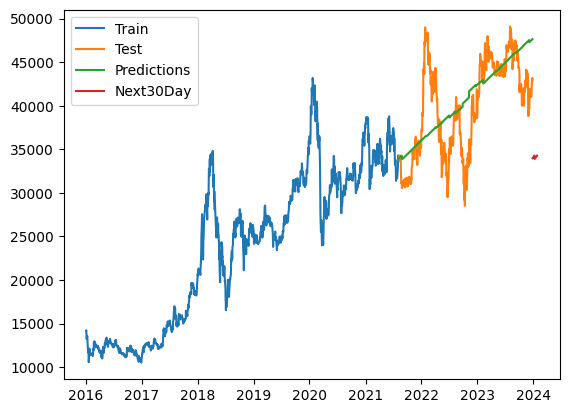

In [12]:
# Generating the next 30 days date indices
last_test_date73 = test_data73.index[-1]
next_30_days_dates73 = pd.date_range(start=last_test_date73 + pd.DateOffset(1), periods=30)

# 10. Vẽ hình 7:3
plt.plot(train_data73.index, train_data73['Price'])
plt.plot(test_data73.index, test_data73['Price'])
plt.plot(test_data73.index, y_pred73)
plt.plot(next_30_days_dates73,y_next_30_days73)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

In [13]:
#RATIO 8:2

In [14]:
# Split the data into training, testing, and validating sets
train_size82 = int(0.8 * len(df))
test_size82 = int(0.2 * len(df))

train_data82 = df[:train_size82]
test_data82 = df[train_size82:train_size82+test_size82]

In [15]:
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data82['Price'], nlags= 700)

In [16]:
# training
y_train82 = np.array(train_data82['Price'])

x_train82 = []
for data in train_data82['High']:
  x_train82.append([data])

model82 = dlm(y_train82)
model82 = model82 + trend(1, discount=0.99, name='Trend', w=1e7)
model82 = model82 + dynamic(features=x_train82, discount=1, name='High')
model82 = model82 + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model82 = model82 + longSeason(period=12, stay=30, data=y_train82, name='season', w=1e7)

model82.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [17]:
# testing
x_test82= []
for data in test_data82['High']:
  x_test82.append([data])

y_test82 = np.array(test_data82['High'])

y_pred82 = model82.predictN(date = model82.n-1, N=len(x_test82),featureDict={'High': x_test82})
y_pred82 = y_pred82[0]


In [18]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Make sure 'Date' is in datetime format
train_data82.index = pd.to_datetime(train_data82.index)

ln_model82 = LinearRegression()

# Use the datetime index for training
ln_model82.fit(np.arange(len(train_data82)).reshape(-1, 1), train_data82['High'])

# Predict the prices for the next 30 days
last_index82 = train_data82.index[-1]
next_30_days_indices82 = np.arange(len(train_data82), len(train_data82) + 30).reshape(-1, 1)

# Use the model to predict the high prices for the next 30 days
high_next_30_days82 = ln_model82.predict(next_30_days_indices82)

# Generate the next 30 days date indices
next_30_days_dates82 = pd.date_range(start=last_index82 + pd.DateOffset(1), periods=30)

# Combine the predicted dates and prices into a DataFrame
predicted_df82 = pd.DataFrame({'Date': next_30_days_dates82, 'Predicted_High': high_next_30_days82})
predicted_df82.set_index('Date', inplace=True)

print(predicted_df82)


            Predicted_High
Date                      
2022-05-28    41173.878149
2022-05-29    41193.171363
2022-05-30    41212.464577
2022-05-31    41231.757791
2022-06-01    41251.051005
2022-06-02    41270.344219
2022-06-03    41289.637432
2022-06-04    41308.930646
2022-06-05    41328.223860
2022-06-06    41347.517074
2022-06-07    41366.810288
2022-06-08    41386.103502
2022-06-09    41405.396716
2022-06-10    41424.689930
2022-06-11    41443.983143
2022-06-12    41463.276357
2022-06-13    41482.569571
2022-06-14    41501.862785
2022-06-15    41521.155999
2022-06-16    41540.449213
2022-06-17    41559.742427
2022-06-18    41579.035641
2022-06-19    41598.328854
2022-06-20    41617.622068
2022-06-21    41636.915282
2022-06-22    41656.208496
2022-06-23    41675.501710
2022-06-24    41694.794924
2022-06-25    41714.088138
2022-06-26    41733.381352


In [19]:
# Dự báo giá cổ phiếu 30 ngày tiếp theo
x_next_30_days82 = []
for data in high_next_30_days82:
  x_next_30_days82.append([data])

y_next_30_days82 = model82.predictN(N = 30, featureDict={'High': x_next_30_days82})
y_next_30_days82 = y_next_30_days82[0]
print(y_next_30_days82)


[35304.69027171789, 35299.0488225674, 35322.130440430454, 35348.50236767312, 35370.74563512916, 35392.24459689811, 35414.320638412384, 35436.543557014214, 35458.68839531025, 35480.806405942196, 35502.93456211183, 35525.067370525416, 35547.198930909166, 35569.329715336695, 35591.46064101974, 35613.59169209592, 35635.7227294473, 35657.85374708362, 35679.98476559984, 35702.11578713878, 35724.24680872725, 35746.3778298634, 35768.508850964834, 35790.639872132306, 35609.453223619596, 35629.94290347851, 35682.04824844668, 35706.26084565538, 35724.00061736088, 35745.553659153185]


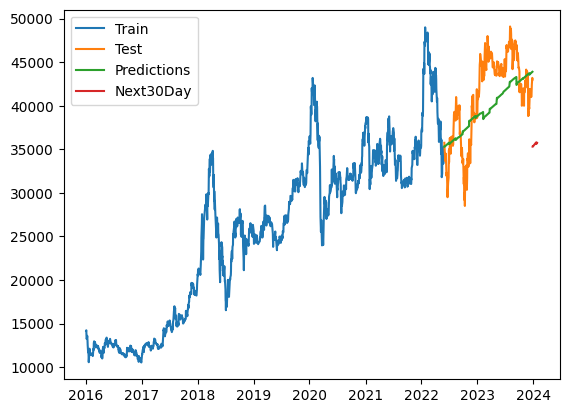

In [20]:
# Generating the next 30 days date indices
last_test_date82 = test_data82.index[-1]
next_30_days_dates82 = pd.date_range(start=last_test_date82 + pd.DateOffset(1), periods=30)
# 10. Vẽ hình
plt.plot(train_data82.index, train_data82['Price'])
plt.plot(test_data82.index, test_data82['Price'])
plt.plot(test_data82.index, y_pred82)
plt.plot(next_30_days_dates82,y_next_30_days82)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

In [21]:
#RATIO 9:1

In [22]:
# Split the data into training, testing, and validating sets
train_size91 = int(0.9 * len(df))
test_size91 = int(0.1 * len(df))

train_data91 = df[:train_size91]
test_data91 = df[train_size91:train_size91+test_size91]

In [23]:
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data91['Price'], nlags= 700)

In [24]:
# 4. Quá trình training
y_train91 = np.array(train_data91['Price'])

x_train91 = []
for data in train_data91['High']:
  x_train91.append([data])

model91 = dlm(y_train91)
model91 = model91 + trend(1, discount=0.99, name='Trend', w=1e7)
model91 = model91 + dynamic(features=x_train91, discount=1, name='High')
model91 = model91 + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model91 = model91 + longSeason(period=12, stay=30, data=y_train91, name='season', w=1e7)

model91.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [25]:
# 5. Quá trình testing
x_test91= []
for data in test_data91['High']:
  x_test91.append([data])

y_test91 = np.array(test_data91['Price'])

y_pred91 = model91.predictN(date = model91.n-1, N=len(x_test91),featureDict={'High': x_test91})
y_pred91 = y_pred91[0]


In [26]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Make sure 'Date' is in datetime format
train_data91.index = pd.to_datetime(train_data91.index)

ln_model91 = LinearRegression()

# Use the datetime index for training
ln_model91.fit(np.arange(len(train_data91)).reshape(-1, 1), train_data91['High'])

# Predict the prices for the next 30 days
last_index91 = train_data91.index[-1]
next_30_days_indices91 = np.arange(len(train_data91), len(train_data91) + 30).reshape(-1, 1)

# Use the model to predict the high prices for the next 30 days
high_next_30_days91 = ln_model91.predict(next_30_days_indices91)

# Generate the next 30 days date indices
next_30_days_dates91 = pd.date_range(start=last_index91 + pd.DateOffset(1), periods=30)

# Combine the predicted dates and prices into a DataFrame
predicted_df91 = pd.DataFrame({'Date': next_30_days_dates91, 'Predicted_High': high_next_30_days91})
predicted_df91.set_index('Date', inplace=True)

print(predicted_df91)


            Predicted_High
Date                      
2023-03-16    43227.298979
2023-03-17    43245.145357
2023-03-18    43262.991734
2023-03-19    43280.838112
2023-03-20    43298.684490
2023-03-21    43316.530868
2023-03-22    43334.377246
2023-03-23    43352.223624
2023-03-24    43370.070001
2023-03-25    43387.916379
2023-03-26    43405.762757
2023-03-27    43423.609135
2023-03-28    43441.455513
2023-03-29    43459.301891
2023-03-30    43477.148268
2023-03-31    43494.994646
2023-04-01    43512.841024
2023-04-02    43530.687402
2023-04-03    43548.533780
2023-04-04    43566.380157
2023-04-05    43584.226535
2023-04-06    43602.072913
2023-04-07    43619.919291
2023-04-08    43637.765669
2023-04-09    43655.612047
2023-04-10    43673.458424
2023-04-11    43691.304802
2023-04-12    43709.151180
2023-04-13    43726.997558
2023-04-14    43744.843936


In [27]:
# 9. Dự báo giá cổ phiếu 30 ngày tiếp theo
x_next_30_days91 = []
for data in high_next_30_days91:
  x_next_30_days91.append([data])

y_next_30_days91 = model91.predictN(N = 30, featureDict={'High': x_next_30_days91})
y_next_30_days91 = y_next_30_days91[0]
print(y_next_30_days91)


[46642.28596669074, 46374.647215116776, 46635.321985520284, 46646.02755586542, 45407.22802096304, 45595.864021477064, 45734.462092068396, 45594.65745470419, 45643.133171290545, 45695.11778727265, 45697.12071916733, 45724.33161762776, 45754.44096908983, 45776.23455810572, 45801.32375749879, 45827.24036820558, 45851.830463959035, 45876.83020625184, 45902.013600244616, 45926.991992983545, 45952.01715761867, 45977.07846874215, 46002.10899552968, 46027.14406653412, 46052.18575164045, 46077.22294607317, 46102.26041841468, 46127.29904091991, 46152.337028733906, 46177.37499417443]


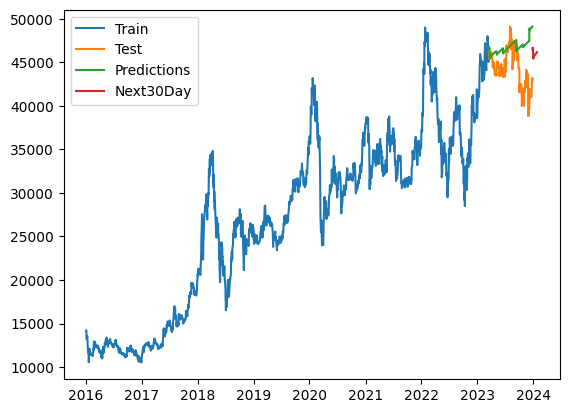

In [28]:
# Generating the next 30 days date indices
last_test_date91 = test_data91.index[-1]
next_30_days_dates91 = pd.date_range(start=last_test_date91 + pd.DateOffset(1), periods=30)
# 10. Vẽ hình
plt.plot(train_data91.index, train_data91['Price'])
plt.plot(test_data91.index, test_data91['Price'])
plt.plot(test_data91.index, y_pred91)
plt.plot(next_30_days_dates91,y_next_30_days91)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

In [29]:
#ACCURACY EVALUATION

In [30]:
#method to calculate mape
def calc_mape(actual, predicted):

    # Convert to numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)

    # Calculate absolute percentage error
    absolute_error = np.abs((actual - predicted) / actual)

    # Handle division by zero cases
    absolute_error[np.isinf(absolute_error)] = 0.0

    # Calculate mean absolute percentage error
    mape = np.mean(absolute_error) * 100

    return mape

In [31]:
#accuracy evaluate 7:3
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_log_error as msle
test_rmse73 = np.sqrt(np.mean((y_pred73 - y_test73)**2))
test_mape73 = calc_mape(y_test73, y_pred73)
test_msle73 = msle(y_test73, y_pred73)

print(test_rmse73)
print(test_mape73)
print(test_msle73)

4288.679657806849
8.640964856258956
0.012052116949706872


In [32]:
#accuracy evaluate 8:2
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_log_error as msle
test_rmse82 = np.sqrt(np.mean((y_pred82 - y_test82)**2))
test_mape82 = calc_mape(y_test82, y_pred82)
test_msle82 = msle(y_test82, y_pred82)

print(test_rmse82)
print(test_mape82)
print(test_msle82)

3972.262534094549
7.968551728313448
0.009249669445439156


In [33]:
#accuracy evaluate 9:1
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_log_error as msle

test_rmse91 = np.sqrt(np.mean((y_pred91 - y_test91)**2))
test_mape91 = calc_mape(y_test91, y_pred91)
test_msle91 = msle(y_test91, y_pred91)

print(test_rmse91)
print(test_mape91)
print(test_msle91)


3617.3874854867454
6.4455310731745445
0.006619428520983855
